Author: Charlie Moffett, NYU CUSP, 2017

# Time Series Clustering Exercise

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import os
import sys
import zipfile 

import pylab as pl
%pylab inline

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GMM
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from scipy.spatial.distance import cdist, pdist

Populating the interactive namespace from numpy and matplotlib


__Download the census bureau business data for all years 1993-2014.__

In [2]:
# unzip NYC zipcode shapefiles in PUIdata
PUIdata = os.getenv('PUIDATA')

if not os.path.isdir(PUIdata + '/ZIP_CODES'):
    print('Download and unzip file...')
    os.system('wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip')
    os.system('mv application%2Fzip ' + PUIdata)
    os.system('unzip ' + PUIdata + '/application%2Fzip -d ' + PUIdata + '/ZIP_CODES')

if os.path.isdir(PUIdata + '/ZIP_CODES'):
    for file in os.listdir(PUIdata + '/ZIP_CODES'):
        if file.endswith('.shp'):
            print('Shapefile in place..')
            shpfile = file

Download and unzip file...
Shapefile in place..


In [3]:
# read in shapefiles using geopandas
dfzip = gpd.read_file(PUIdata + "/ZIP_CODES/ZIP_CODE_040114.shp")
dfzip.head(2)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."


In [4]:
dfzip = dfzip[['ZIPCODE', 'geometry']]
dfzip['ZIPCODE'] = pd.to_numeric(dfzip['ZIPCODE'])
dfzip.head(2)

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."


In [5]:
ts_df = pd.DataFrame()

In [6]:
for i in range(94,100):
    fname='zbp' + str(i) + 'totals.zip'
    time = 1900 + i
    zf = zipfile.ZipFile(PUIdata + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt'))).assign(year=time)
    df.columns = [x.upper() for x in df.columns]
    df = df[['ZIP', 'EST', 'YEAR']]
    ts_df = ts_df.append(df)
    

for i in range(0,15):
    fname='zbp' + str(i).zfill(2) + 'totals.zip'
    time = 2000 + i
    zf = zipfile.ZipFile(PUIdata + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt'))).assign(year=time)
    df.columns = [x.upper() for x in df.columns]
    df = df[['ZIP', 'EST', 'YEAR']]
    ts_df = ts_df.append(df)
    
ts_df.shape

(828791, 3)

## Data Cleaning Tasks

In [7]:
# 1. get and prep my data
ts_df = pd.pivot_table(ts_df, values='EST', index='ZIP', columns='YEAR')
ts_df.dropna(axis=0, inplace=True)

In [8]:
merge_df = dfzip.merge(ts_df, right_index=True, left_on='ZIPCODE')
merge_df.drop('geometry', axis=1, inplace=True)
merge_df.set_index('ZIPCODE', inplace=True)
merge_df.head(2)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0


In [9]:
df_stan = ((merge_df.T - merge_df.mean(axis=1)) / merge_df.std(axis=1)).T
df_stan.shape

(243, 21)

In [10]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k, random_state=123).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    pl.grid(True)
    pl.xlabel('Number of clusters')
    pl.ylabel('Percentage of variance explained')
    pl.title('Elbow for KMeans clustering')
    pl.show()

For n_clusters = 2 The average silhouette_score is : 0.572142801777
For n_clusters = 3 The average silhouette_score is : 0.541072613328
For n_clusters = 4 The average silhouette_score is : 0.501207133658
For n_clusters = 5 The average silhouette_score is : 0.331797446821
For n_clusters = 6 The average silhouette_score is : 0.32721517486
For n_clusters = 7 The average silhouette_score is : 0.251977848353
For n_clusters = 8 The average silhouette_score is : 0.241967649096
For n_clusters = 9 The average silhouette_score is : 0.158254524982
For n_clusters = 10 The average silhouette_score is : 0.150430762634


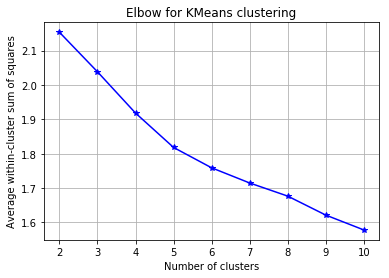

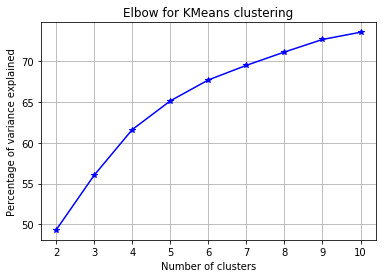

In [11]:
# 2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
range_n_clusters = range(2,11)
for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = clusterer.fit_predict(df_stan)
    silhouette_avg = silhouette_score(df_stan, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(df_stan, cluster_labels)
elbow(df_stan,range_n_clusters)

In [12]:
# 3. plot the cluster centers
n = 5
km = KMeans(n_clusters=n, random_state=123)
km_res = km.fit(df_stan)

agc = AgglomerativeClustering(n_clusters=n,  compute_full_tree=True)
agc_res = agc.fit(df_stan)

df_stan['KLABEL'] = km_res.labels_
df_stan['AGCLABEL'] = agc_res.labels_

In [13]:
centersKM = pd.DataFrame(km_res.cluster_centers_)
centersKM.columns = df_stan.columns[:-2]
centersKM.head(2)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,-1.329773,-1.253106,-1.154477,-1.006409,-0.905354,-0.871665,-0.747412,-0.650730,-0.285028,-0.143496,...,0.145892,0.189600,0.376000,0.499544,0.625136,0.876965,1.042539,1.278769,1.537003,1.750877
1,1.228315,0.744933,0.240404,-0.150314,-0.341420,0.036786,-0.258669,-0.411081,-0.824537,-0.953571,...,-0.417455,-0.436914,-0.162135,-0.198708,-0.056953,0.027780,0.166045,0.665710,0.717353,0.976713


In [14]:
geo_cluster = dfzip.merge(df_stan, left_on='ZIPCODE', right_index=True)
geo_cluster.head(2)

,ZIPCODE,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,KLABEL,AGCLABEL
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,...,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,0,3
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,...,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,0,3


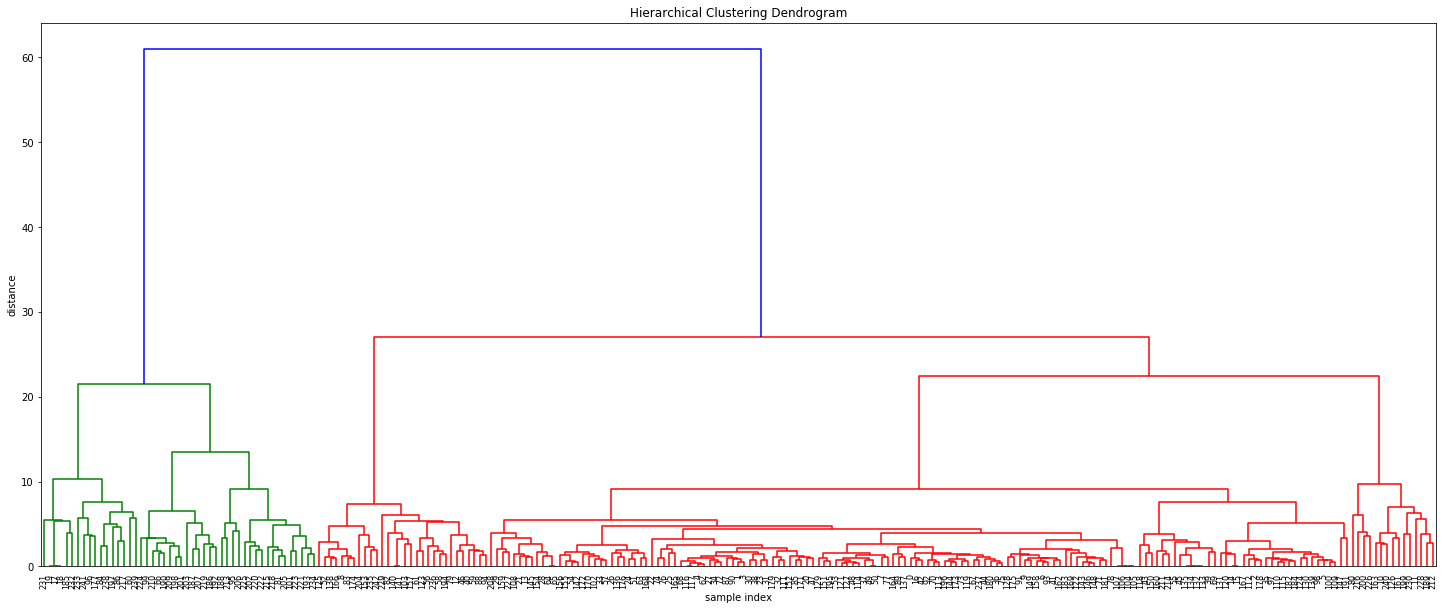

In [15]:
#4. Use another clustering algorithm (of your choice)
Z = linkage(df_stan, 'ward')
c, coph_dists = cophenet(Z, pdist(df_stan))

# calculate dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,)
pl.show()

__Figure 1: This plot exhibits a hierarchical clustering dendrogram, exploring our same data with another clustering algorithm of my choice. Bottom-up algorithms like this one treat each document as a singleton cluster at the outset and then successively merge (or agglomerate) pairs of clusters until all clusters have been merged into a single cluster that contains all documents.__

(905410.75604293647,
 1075212.5382562785,
 112386.35181947277,
 280345.45402395504)

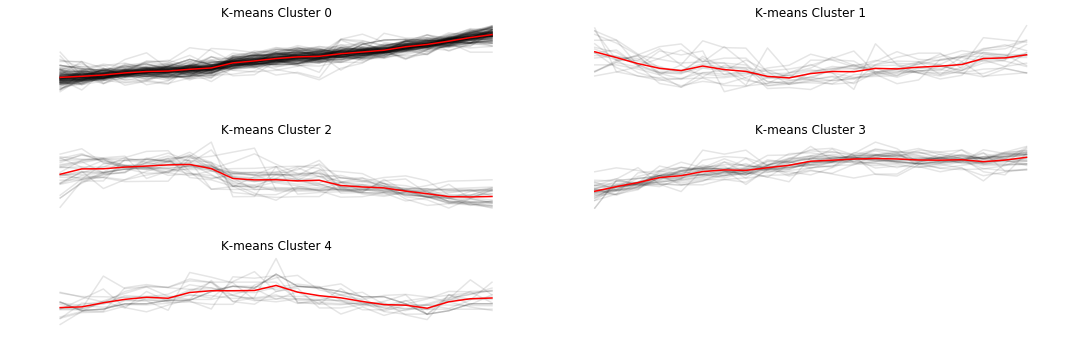

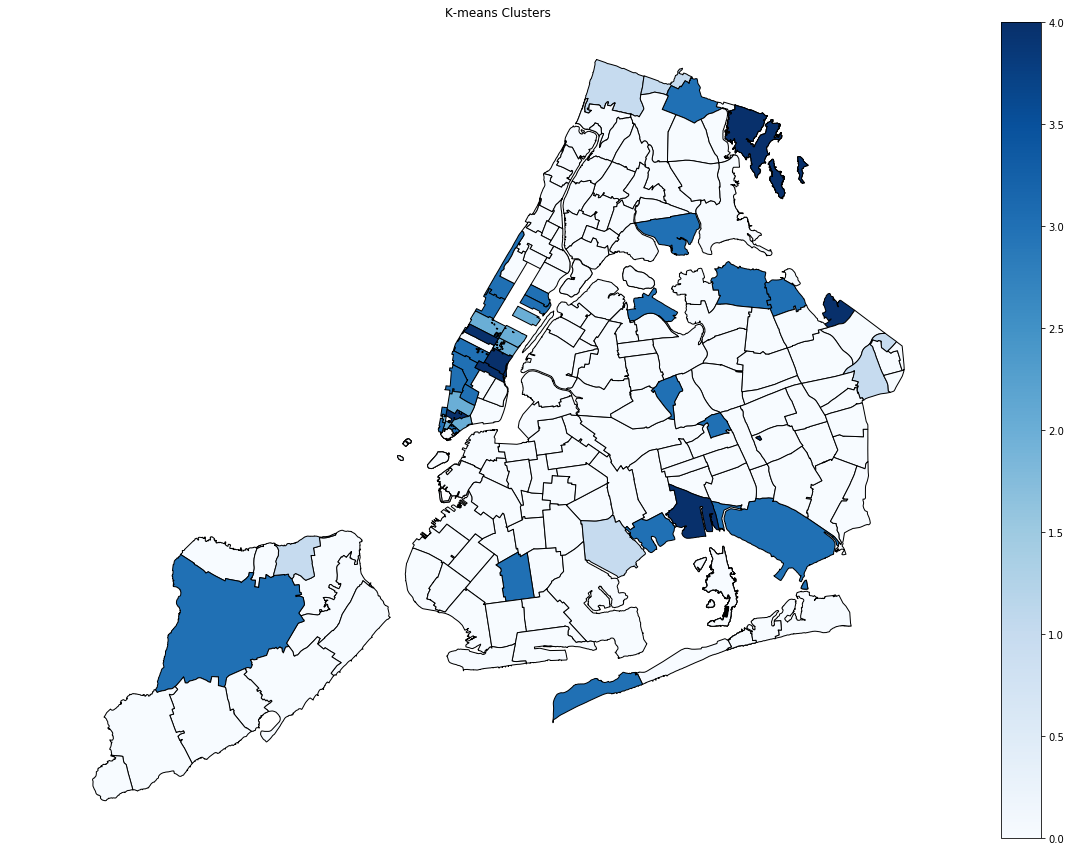

In [16]:
# 5. overlay your data on a NYC map

fig = pl.figure(figsize=(15,5))

for k in range(n):
    ax = fig.add_subplot(3,2,k+1)
    cluster = df_stan[df_stan['KLABEL'] == k]
    ax.plot(cluster.iloc[:,:-2].T, c='k', alpha=0.1)
    ax.plot(centersKM.iloc[k], c='r')
    ax.set_title("K-means Cluster {}".format(str(k)))
    ax.axis('off')
    
pl.tight_layout()

fig2 = pl.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)

geo_cluster.plot(ax=ax2, column='KLABEL', cmap='Blues', edgecolor='k', lw=1, legend=True)
ax2.set_title('K-means Clusters')
ax2.axis('off')

__Figure 2: Overlay of the data on an NYC map by zip code. The various shades of blue represent different clusters of businesses/establishments.__

(905410.75604293647,
 1075212.5382562785,
 112386.35181947277,
 280345.45402395504)

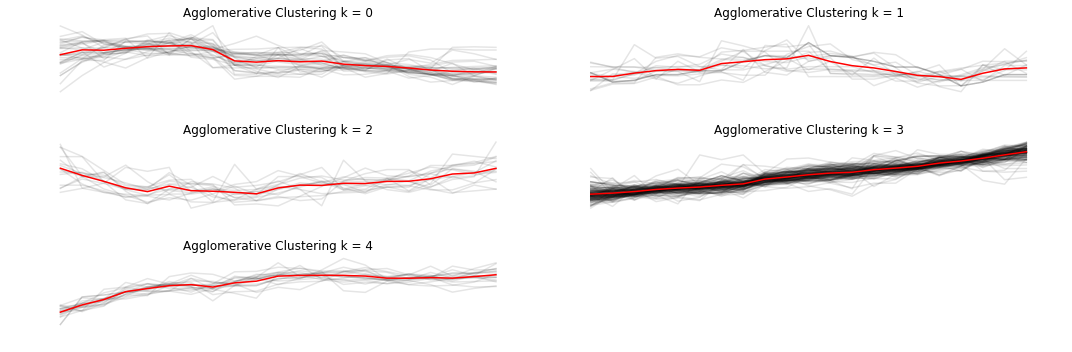

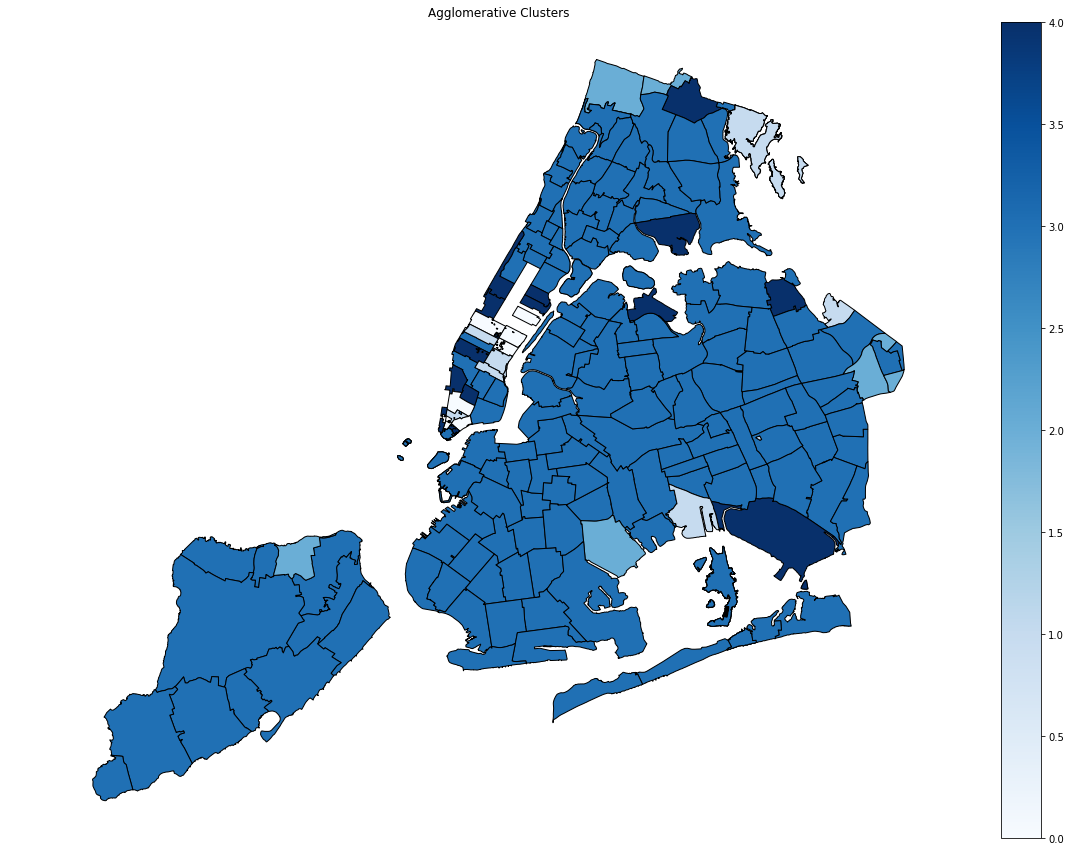

In [17]:
# 6. Compare the results of the 2 algorithms

fig = pl.figure(figsize=(15,5))

for k in range(n):
    ax = fig.add_subplot(3,2,k+1)
    cluster = df_stan[df_stan['AGCLABEL'] == k]
    ax.plot(cluster.iloc[:,:-2].T, c='k', alpha=0.1)
    ax.plot(cluster.iloc[:,:-2].mean(), c='r')
    ax.set_title("Agglomerative Clustering k = {}".format(str(k)))
    ax.axis('off')
    
pl.tight_layout()

fig2 = pl.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)

geo_cluster.plot(ax=ax2, column='AGCLABEL', cmap='Blues', edgecolor='k', lw=1, legend=True)
ax2.set_title('Agglomerative Clusters')
ax2.axis('off')

__Figure 3: Similar plot to 2 except that here we perform agglomerative clustering.__

#7. attempt an interpretation.

__Clustering is an exploratory tool, so I don't want to jump to conclusions just because I see some clusters! However, seeing structure in our data can certainly be informative.__

__From the looks of our spatial visualization of establishment clusters, it would appear that there is some sort of specialization going on with businesses close to the water, perhaps entities engaged in waterborn trade or some aspect of the ports. As far as cluster variety goes, there's quite a bit of distinction going on just within lower Manhattan alone, which would make sense give the centralization of commerce and business more broadly in that region of the city.__

Points: 10